# BVCBM prior samples and biphasic simulations
This notebook snippet draws samples from the biphasic prior and runs the simulator at those draws.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from precond_npe_misspec.examples import bvcbm

try:
    from scipy.io import loadmat
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "scipy is required to read '.mat' files. Install it with `uv run --with scipy` or `pip install scipy`."
    ) from exc

plt.style.use("ggplot")

/Users/ryankelly/python_projects/preconditioned-npe-under-misspecification/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T = 32  # simulation horizon (days)
start_volume = 50.0
page = 5
num_prior_draws = 10

key = jax.random.key(0)
prior = bvcbm.prior_biphasic(T)
key_samples, key_sims = jax.random.split(key)
theta_samples = prior.sample(key_samples, sample_shape=(num_prior_draws,))
theta_samples_np = np.asarray(theta_samples)
parameter_labels = [
    "p0_1",
    "psc_1",
    "dmax_1",
    "gage_1",
    "p0_2",
    "psc_2",
    "dmax_2",
    "gage_2",
    "tau",
]
pd.DataFrame(theta_samples_np, columns=parameter_labels)

,p0_1,psc_1,dmax_1,gage_1,p0_2,psc_2,dmax_2,gage_2,tau
0,0.842314,0.182379,11.358905,93.596558,0.191813,0.722015,38.272278,117.998520,29.599482
1,0.029310,0.098711,27.657164,96.450928,0.594562,0.959491,34.661358,556.381592,11.226767
2,0.820071,0.641026,13.149339,148.276276,0.775891,0.856076,40.907753,239.726074,25.572996
3,0.950055,0.005937,33.533798,741.473572,0.120370,0.278026,49.205135,605.924377,14.230344
4,0.040947,0.205704,0.453585,721.785583,0.920053,0.636973,26.245148,671.601257,14.060402
5,0.367051,0.754542,18.360746,529.188538,0.583788,0.034946,48.511452,615.362427,29.673931
6,0.950138,0.220175,44.330025,128.111710,0.857906,0.429678,40.306561,505.176147,9.752800
7,0.591107,0.006508,11.865783,327.482422,0.991457,0.036244,7.501406,79.538017,3.934545
8,0.533955,0.964188,44.966106,529.239624,0.701765,0.755199,40.090149,345.352081,9.302969
9,0.931869,0.434670,1.851267,208.846329,0.970559,0.354628,49.820564,231.137177,28.537561


In [3]:
sim = bvcbm.simulator_biphasic(T=T, start_volume=start_volume, page=page)
sim_seed_ints = jax.random.randint(
    key_sims, shape=(num_prior_draws,), minval=0, maxval=2**31 - 1, dtype=jnp.int32
)
sim_results = [
    sim(theta, int(seed))
    for theta, seed in zip(theta_samples_np, np.asarray(sim_seed_ints))
]
sim_results = np.asarray(sim_results, dtype=float)
sim_results

array([[9.26931505e+02, 2.61612131e+03, 5.00878549e+03, 8.69908973e+03,
        1.34810029e+04, 1.89421488e+04, 2.54970673e+04, 3.40416128e+04,
        4.73073601e+04, 5.83582320e+04, 7.17793153e+04, 9.31709273e+04,
        1.14946450e+05, 1.42396300e+05, 1.72081436e+05, 2.03825930e+05,
        2.41783080e+05, 2.84439860e+05, 3.27797277e+05, 3.78546057e+05,
        4.33917824e+05, 4.99350973e+05, 5.64846074e+05, 6.25590759e+05,
        7.08131915e+05, 7.93218930e+05, 8.87365039e+05, 9.75421195e+05,
        1.06092951e+06, 1.13942817e+06, 1.34629997e+06, 1.54537096e+06],
       [1.36449977e+02, 2.65158579e+02, 4.79678692e+02, 9.24794121e+02,
        1.02850639e+03, 1.75648844e+03, 2.22611970e+03, 2.47303945e+03,
        3.22080960e+03, 3.99528411e+03, 4.48125714e+03, 7.17755720e+03,
        7.85031195e+03, 8.10941474e+03, 8.58570751e+03, 1.02905096e+04,
        1.07773652e+04, 1.05522794e+04, 1.07956702e+04, 1.18576278e+04,
        1.26205881e+04, 1.33495219e+04, 1.45881079e+04, 1.75649

In [4]:
prior_summary_log = np.asarray([bvcbm.summary_identity(s) for s in sim_results])
prior_summary_log.shape

(10, 32)

In [7]:
data_path = Path("../src/precond_npe_misspec/data/CancerDatasets.mat")
mat = loadmat(data_path, squeeze_me=True)
control_growth = np.asarray(mat["Breast_data"], dtype=float)
control_growth = control_growth[:T, 3]
control_growth = np.squeeze(control_growth)
real_summary_log = bvcbm.summary_identity(control_growth)
control_growth.shape, real_summary_log.shape

((32,), (32,))

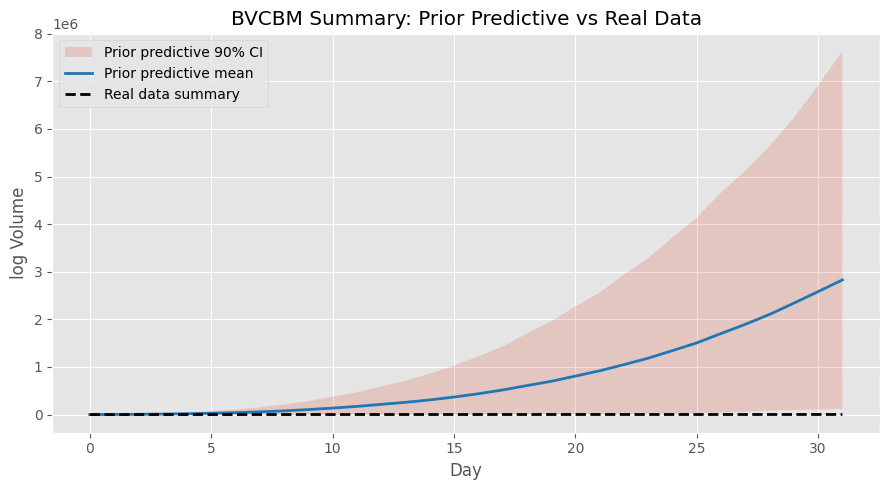

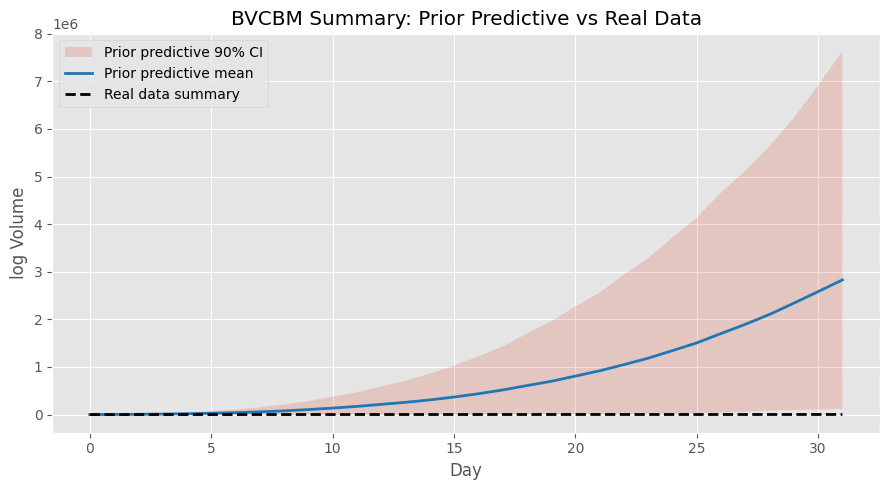

In [8]:
time_idx = np.arange(prior_summary_log.shape[1])
prior_lower, prior_upper = np.percentile(prior_summary_log, [5, 95], axis=0)
prior_mean = prior_summary_log.mean(axis=0)

fig, ax = plt.subplots(figsize=(9, 5))
ax.fill_between(
    time_idx, prior_lower, prior_upper, alpha=0.2, label="Prior predictive 90% CI"
)
ax.plot(
    time_idx, prior_mean, color="tab:blue", linewidth=2, label="Prior predictive mean"
)
ax.plot(
    time_idx,
    real_summary_log,
    color="black",
    linewidth=2,
    linestyle="--",
    label="Real data summary",
)
ax.set_xlabel("Day")
ax.set_ylabel("log Volume")
ax.set_title("BVCBM Summary: Prior Predictive vs Real Data")
ax.legend()
fig.tight_layout()
fig